In [1]:
from pathlib import Path

twitter_datasetFolder = Path("../datasets/twitter")
exp01c_resultsFolder = Path("../experiments/exp02/results")

In [2]:
import pandas as pd
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
# Show all columns in a single line without wrapping
pd.set_option('display.max_columns', None)
# Also, make the display wider so it fits more
pd.set_option('display.width', 2000)

In [3]:
# load twitter dataset
twitter_dataset = pd.read_csv(twitter_datasetFolder / "index.csv")
# columns tweet_id must be loaded as string
twitter_dataset["tweet_id"] = twitter_dataset["tweet_id"].astype(str)
# map class column to 1 and 0
twitter_dataset["class"] = twitter_dataset["class"].map({"positive": 1, "negative": 0})

print(twitter_dataset.head())



              tweet_id  class  error[Truncated axis]  error[Dual axis]  error[Value as area/volume]  error[Inverted axis]  error[Uneven binning]  error[Unclear encoding]  error[Inappropriate encoding]  error[Cherry-picking]  error[Setting an arbitrary threshold]  error[Causal inference]  error[Issues with data validity]  error[Failure to account for statistical nuance]  error[Misrepresentation of scientific studies]  error[Incorrect reading of chart]
0  1220060594868555778      1                  False             False                         True                 False                  False                    False                          False                  False                                  False                    False                             False                                             False                                           False                              False
1  1234688701114060800      1                  False             False                    

In [4]:
# load model results. structure: results[modelName][tweet_id] = result_dict
results = {}

for modelFolder in exp01c_resultsFolder.glob("*"):
    if not modelFolder.is_dir():
        continue
    modelName = modelFolder.name
    results[modelName] = {}

    for resultFile in modelFolder.glob("*.json"):
        with open(resultFile, "r") as f:
            result = json.load(f)
            twid = result["tweet_id"]
            results[modelName][twid] = result
    print(f"Loaded model results: {modelName} -- {len(results[modelName])} tweets")

Loaded model results: qwen2.5vl:72b -- 2336 tweets
Loaded model results: gemma3:27b -- 2336 tweets


In [5]:
# analysis of classification results
df_classification = twitter_dataset.copy()[["tweet_id", "class"]]


for modelName in sorted(results.keys()):
    df_classification.insert(len(df_classification.columns), modelName, 1)
    for tweetId in results[modelName]:
        result = results[modelName][tweetId]
        isMisleading = result["response"]["misleading_info"]["is_misleading"]
        df_classification.loc[df_classification["tweet_id"] == tweetId, modelName] = int(isMisleading)


print("Classification Results RAW:")
print(df_classification.head())

Classification Results RAW:
              tweet_id  class  gemma3:27b  qwen2.5vl:72b
0  1220060594868555778      1           1              0
1  1234688701114060800      1           1              0
2  1236331391643779074      1           1              1
3  1238453491917631489      1           1              0
4  1239398342599364609      1           1              1


In [6]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix
)
import pandas as pd

df = df_classification.copy()
summary = []

_ROUNDING = 3  # decimal places for rounding metrics

for modelName in sorted(results.keys()):
    y_true = df["class"].astype(int)
    y_pred = df[modelName].astype(int)

    # Main metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    # Macro averages (treat both classes equally)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    precision_macro = precision_score(y_true, y_pred, average="macro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    

    # Per-class metrics
    precision_0 = precision_score(y_true, y_pred, pos_label=0)
    recall_0 = recall_score(y_true, y_pred, pos_label=0)
    f1_0 = f1_score(y_true, y_pred, pos_label=0)

    precision_1 = precision_score(y_true, y_pred, pos_label=1)
    recall_1 = recall_score(y_true, y_pred, pos_label=1)
    f1_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    summary.append({
        "model": modelName,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "precision_NotMis": precision_0,
        "recall_NotMis": recall_0,
        "f1_NotMis": f1_0,
        "precision_Mis": precision_1,
        "recall_Mis": recall_1,
        "f1_Mis": f1_1,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

summary_df = pd.DataFrame(summary).round(_ROUNDING)
summary_df = summary_df.sort_values(by="roc_auc", ascending=False)

print("\n\nSummary of classification metrics:\n\n")

print(summary_df)

print("\n\n--------------------------------------------------\n\n")
print("Detailed classification reports:\n\n")

for modelName in sorted(results.keys()):
    y_true = df["class"]
    y_pred = df[modelName]

    print(f"Classification report for {modelName}:")
    print(classification_report(y_true, y_pred, target_names=["not-misleading", "misleading"], digits=_ROUNDING))
    
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"\nROC AUC score for {modelName}: {roc_auc}\n")

    print(f"Confusion matrix for {modelName}:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\n\n--------------------------------------------------\n\n")




Summary of classification metrics:


           model  accuracy  roc_auc  f1_macro  precision_macro  recall_macro  precision_NotMis  recall_NotMis  f1_NotMis  precision_Mis  recall_Mis  f1_Mis    TP    FP   FN   TN
1  qwen2.5vl:72b     0.590    0.590     0.584            0.596         0.590             0.621          0.465      0.532          0.572       0.716   0.636   836   625  332  543
0     gemma3:27b     0.511    0.511     0.366            0.625         0.511             0.745          0.033      0.062          0.505       0.989   0.669  1155  1130   13   38


--------------------------------------------------


Detailed classification reports:


Classification report for gemma3:27b:
                precision    recall  f1-score   support

not-misleading      0.745     0.033     0.062      1168
    misleading      0.505     0.989     0.669      1168

      accuracy                          0.511      2336
     macro avg      0.625     0.511     0.366      2336
  weighted avg   

In [7]:
subtable = summary_df[["model", "accuracy", "TP", "FP", "TN", "FN"]]
print("Subtable:")
print(subtable)

Subtable:
           model  accuracy    TP    FP   TN   FN
1  qwen2.5vl:72b     0.590   836   625  543  332
0     gemma3:27b     0.511  1155  1130   38   13


In [8]:
def get_rhetoric_usage_df(modelName, results, tweetsIDs = None):
    """Build a DataFrame indicating the usage of rhetorics for the given model and tweets ids.
    """
    rhetorics = [ 
        'Information_Access_Rhetoric',
        'Provenance_Rhetoric',
        'Mapping_Rhetoric',
        'Linguistic_Based_Rhetoric',
        'Procedural_Rhetoric'
    ]

    if tweetsIDs is None:
        tweetsIDs = list(results[modelName].keys())

    df = []
    for twid in tweetsIDs:
        d = {"tweet_id": twid}
        for rhet in rhetorics:
            try:
                # check if rhetorics exists and supports_misleading
                d[rhet] = results[modelName][twid]["response"]["visualization_rethoric"][rhet]["exists"] and results[modelName][twid]["response"]["visualization_rethoric"][rhet]["supports_misleading"] 
            except Exception as e:
                d[rhet] = None
                print(tweetId, rhet, e)
        df.append(d)


    df = pd.DataFrame(df)
    return df

In [9]:
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

def get_upset_rhetoric(df_rhetoric, title, facecolor="#4d4947", outputPath=None):
    ### upset plot of rhetoric types ###
    labels_pretty = [
        "Information Access",
        "Provenance",
        "Mapping",
        "Linguistic Based",
        "Procedural"
    ]

    df = df_rhetoric.copy()
    # remove twwet_id column
    del df["tweet_id"]

    # set pretty labels
    df.columns = labels_pretty

    # Build upset data
    upset_data = from_indicators(labels_pretty, df)

    # Plot
    fig = plt.figure(figsize=(10, 6))
    UpSet(upset_data, show_counts=True, sort_by='degree', facecolor=facecolor).plot(fig=fig)

    fig.suptitle(title, y=1.05)
    if outputPath is not None:
        plt.savefig(outputPath, bbox_inches='tight')
    plt.show()
    plt.close()

In [10]:
REF_MODEL = summary_df["model"].iloc[0]


# get real misleading tweets that are correctly identified by the reference model (TP true positives)
df_TP = df_classification[[ "tweet_id", "class", REF_MODEL]]
df_TP = df_TP[(df_TP["class"] == 1) & (df_TP[REF_MODEL] == 1)]
# add intentionalitiy of misleading
df_TP["is_intentional"] = df_TP["tweet_id"].apply(lambda twid: results[REF_MODEL][twid]["response"]["misleading_info"]["is_intentional"])
print(f"Number of real misleading tweets correctly identified (TP) by {REF_MODEL}: {len(df_TP)}")
print(f" - of which INTENTIONAL: {len(df_TP[df_TP['is_intentional'] == True])} percent: {len(df_TP[df_TP['is_intentional'] == True]) / len(df_TP) * 100:.2f}%")
print(f" - of which NON INTENTIONAL: {len(df_TP[df_TP['is_intentional'] == False])} percent: {len(df_TP[df_TP['is_intentional'] == False]) / len(df_TP) * 100:.2f}%")


df_ALL_rhetoric = get_rhetoric_usage_df(REF_MODEL, results)
df_ALL_POSITIVE_rhetoric = get_rhetoric_usage_df(REF_MODEL, results, tweetsIDs=df_classification[df_classification["class"] == 1]["tweet_id"].tolist())
df_TP_rhetoric = get_rhetoric_usage_df(REF_MODEL, results, tweetsIDs=df_TP["tweet_id"].tolist())
df_TP_intentional_rhetoric = get_rhetoric_usage_df(REF_MODEL, results, tweetsIDs=df_TP[df_TP["is_intentional"] == True]["tweet_id"].tolist())
df_TP_non_intentional_rhetoric = get_rhetoric_usage_df(REF_MODEL, results, tweetsIDs=df_TP[df_TP["is_intentional"] == False]["tweet_id"].tolist())

df_TP_rhetoric_intentionality = df_TP_rhetoric.copy()
df_TP_rhetoric_intentionality.insert(1, "is_intentional", df_TP["is_intentional"].values)




Number of real misleading tweets correctly identified (TP) by qwen2.5vl:72b: 836
 - of which INTENTIONAL: 409 percent: 48.92%
 - of which NON INTENTIONAL: 427 percent: 51.08%


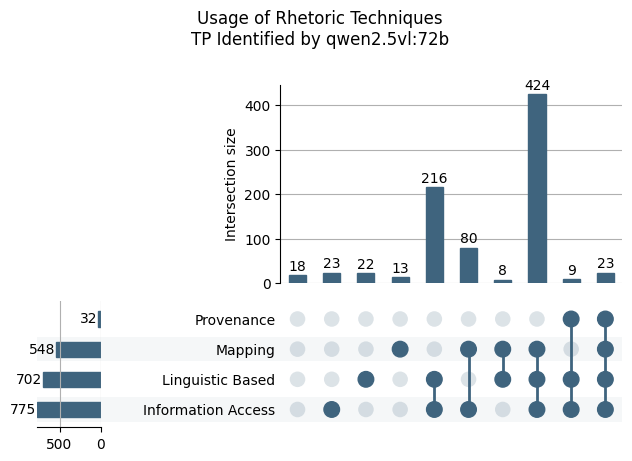

In [11]:
get_upset_rhetoric(
    df_TP_rhetoric,
    title=f"Usage of Rhetoric Techniques\nTP Identified by {REF_MODEL}",
    facecolor="#3F647E",
    #outputPath=f"upset_chart_rhetoric_types_ALL {REF_MODEL}.pdf"
)

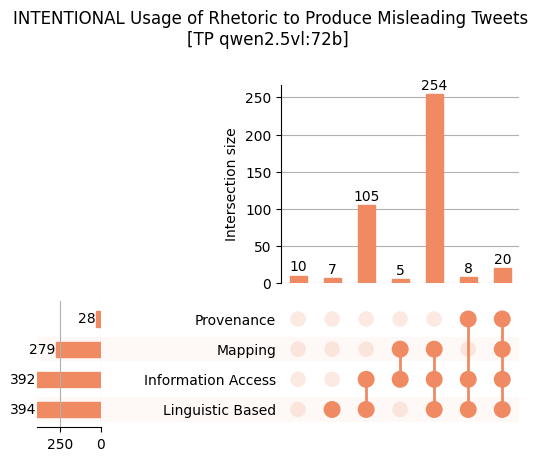

In [12]:
get_upset_rhetoric(
    df_TP_intentional_rhetoric,
    title=f"INTENTIONAL Usage of Rhetoric to Produce Misleading Tweets\n[TP {REF_MODEL}] ",
    facecolor='#ef8a62',
    #outputPath="upset_chart_rhetoric_types_TP_intentional.pdf"
)

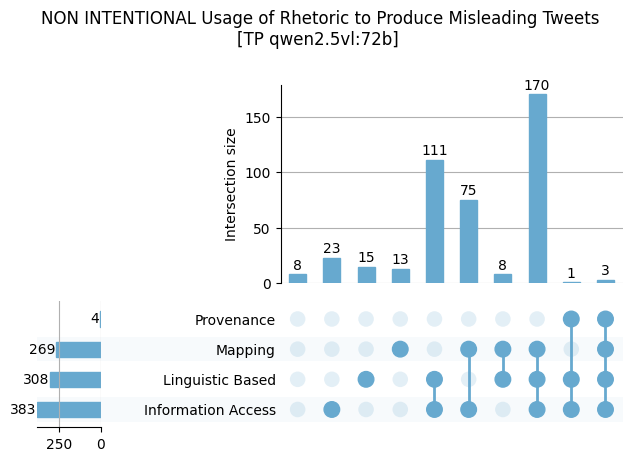

In [13]:
get_upset_rhetoric(
    df_TP_non_intentional_rhetoric,
    title=f"NON INTENTIONAL Usage of Rhetoric to Produce Misleading Tweets\n[TP {REF_MODEL}] ",
    facecolor='#67a9cf',
    #outputPath="upset_chart_rhetoric_types_TP_nonintentional.pdf"
)